## Required libraries

In [1]:
from utils.rawdata_prep import *
from scipy.io import loadmat
import matplotlib.pyplot as plt
import random
import cv2
from random import shuffle

## Download Dataset

1. Download the Flickr Portrait Dataset from Dropbox
2. Unzip dataset file
3. Download online Images
4. **Skip to the cell titled "*load dataset*" if you already have generated the pickle file**

In [ ]:
dwnld = DownloadEG()
dwnld.run()

## Build Dataset

 1. Check that the dataset folder exists.
 2. Create a list of dictionaries: `[ {"img":image_path, "mask": mask_path, "crop": crop_specs}, {..}, ....]`
 3. Save it in a pickle file for future use (`eg_dataset.pickle`).
 
 Each image is cropped according to specs given by `crop_specs`:  `[y0, y1, x0, x1]`.

In [2]:
eg_prep = EGDataset()
eg_prep.build_dataset() #save the pickle file "eg_dataset.pickle"

Check saved Dataset: .... 
No error found!
EG dataset saved in `eg_dataset.pickle`.


In [3]:
#load dataset
with open("eg_dataset.pickle", 'rb') as handle:
    dataset = pickle.load(handle)
    

dataset_sz = len(dataset)

print("Size dataset: {}".format(dataset_sz))

Size dataset: 1768


## Visualization of a few examples

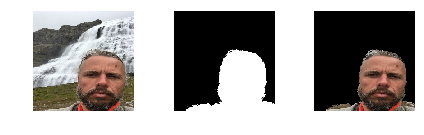

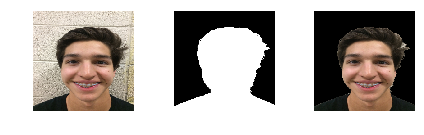

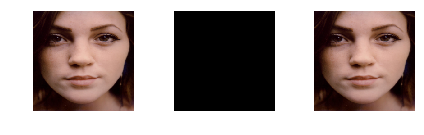

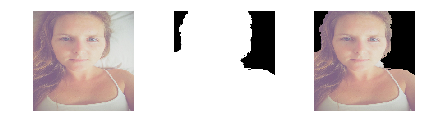

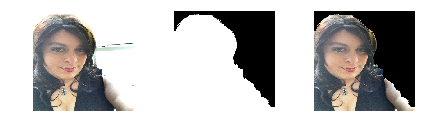

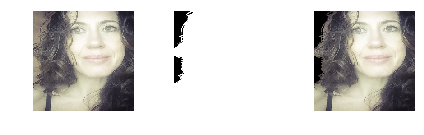

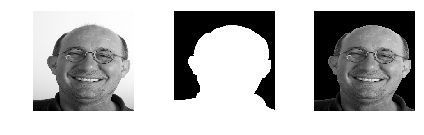

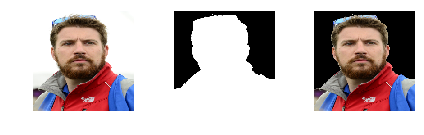

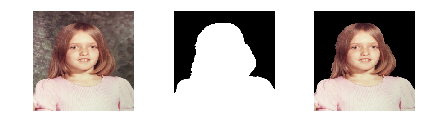

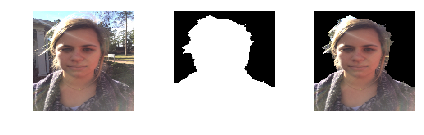

In [4]:
def read_mask_mat(mat_fname, mask_sz):
    """
    extract mask as a binary image array
        :mat_fname: str
        :mask_sz: tuple
    """
    mat = loadmat(mat_fname)
    mask = mat["mask"]
    mask = mask.astype( np.float32 )
    mask_rsz = cv2.resize(mask, mask_sz)
    mask_rsz = np.expand_dims(mask_rsz, axis=2)
    return mask_rsz


def read_image_file(img_fname, crop, img_input_sz):
    """
    read raw image, resize and output array
    """
    bgr = cv2.imread( img_fname )
    rgb = bgr[:, :, ::-1]
    if np.sum(crop) != 0: #image must be cropped
        assert len(crop)==4, "crop specs list must be of length 4"
        yi, yf, xi, xf = crop
        rgb = rgb[yi:yf, xi:xf, :]
    
    rgb_rsz = cv2.resize(rgb, (600, 800))
    img_rsz = cv2.resize(rgb_rsz, img_input_sz)
    return img_rsz


examples_id = np.random.choice(range(dataset_sz), 10)

mask_sz, img_input_sz = (224, 224), (224, 224) # The model takes images of that size

for idx in examples_id:
    example = dataset[idx]
    mask = read_mask_mat(example["mask"], mask_sz)
    img = read_image_file(example["img"], example["crop"], img_input_sz)
    combo = mask * img
    f, ax = plt.subplots(1, 3)
    ax[0].imshow(img)
    ax[1].imshow(mask[:,:,0], cmap="gray")
    ax[2].imshow(combo.astype("uint8"))
    ax[0].axis("off"), ax[1].axis("off"), ax[2].axis("off")
    plt.tight_layout()
    plt.show()

## Average Mask

Get insight about the average position of the subject/person wrt the frame

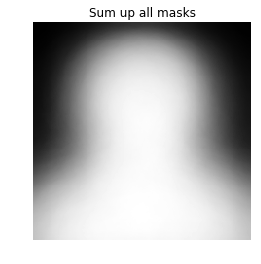

In [5]:
avg_mask = np.zeros((mask_sz[0], mask_sz[1], 1))
for exple in dataset:
    mat_p = exple["mask"]
    img = read_mask_mat(mat_p, img_input_sz)
    avg_mask += img
    plt.axis("off")
plt.imshow(avg_mask[:,:,0], cmap="gray")
plt.title("Sum up all masks")
plt.show()

## Validation set split

Split data into training and validation set with ratio 0.8:0.2

In [6]:
split_ratio = 0.8 

indexes = [i for i in range(dataset_sz)]
random.shuffle(indexes)
split_idx = int( dataset_sz * split_ratio )
train_indexes = indexes[0:split_idx]
train_sz = len(train_indexes)
valid_indexes = indexes[split_idx::]
valid_sz = len(valid_indexes)

print("Training set size {} | Validation set size {}".format(train_sz, valid_sz))

Training set size 1414 | Validation set size 354


## Generator

In [7]:
def read_img(img_path, crop_specs, input_sz=(224, 224)):
    """
    Read image file and return cropped, resized, intensity-normalized array
        Arguments
            :img_path: str
            :crop_specs: list
            :input_sz: tuple
        Output
            :rgb_norm: numpy array
    """
    bgr = cv2.imread(img_path)
    rgb = bgr[:,:,::-1]
    if len(crop_specs) == 4:
        rgb = rgb[ crop_specs[0]:crop_specs[1], crop_specs[2]:crop_specs[3], :]
    rgb = cv2.resize(rgb, (600, 800))
    rgb = cv2.resize(rgb, input_sz)
    rgb_norm = rgb.astype(np.float32)/ 255.
    
    return rgb_norm



def read_mask(mask_path, input_sz=(224, 224)):
    """
    Read mat file with binary mask and returns an array of rank 3
        Arguments
            :mask_path: str
            :input_sz: tuple
        Output
            :mask: numpy array
    """
    mask_mat = loadmat( mask_path )
    mask = mask_mat["mask"]
    mask = cv2.resize(mask, (224, 224))
    mask = np.expand_dims(mask, axis=2)
    
    return mask



def batch_gen(batch_sz, indexes, dataset, is_training):
    """
    """
    idx = 0 # pointer for indexes
    
    while 1:
        if is_training: shuffle(indexes)
        x_batch = np.zeros( (batch_sz, 224, 224, 3), dtype=np.float32)
        y_batch = np.zeros( (batch_sz, 224, 224, 1), dtype=np.float32)
        
        for row in range(batch_sz):
            example = dataset[indexes[idx]]
            crop_specs = example["crop"]
            img_path = example["img"]
            mask_path = example["mask"]
            rgb_norm = read_img(img_path, crop_specs)
            mask = read_mask(mask_path)
            x_batch[row] = rgb_norm[:,:,:]
            y_batch[row] = mask[:, :, :]
            idx += 1
            if (idx > len(indexes)-1):
                shuffle(indexes)
                idx = 0

        yield x_batch, y_batch

## Segmentation Model

Original model from:

https://github.com/akirasosa/mobile-semantic-segmentation

1. the loss function is replaced by a simple log-loss.
2. the `BilinearUpSampling` layer is replaced by `UpSampling2D`

In [10]:
import keras
import keras.backend as K
from keras import Input
from keras.optimizers import Adam
from keras.engine import Model
from keras.layers import BatchNormalization, Activation, Conv2D, concatenate, Conv2DTranspose, UpSampling2D
from keras.applications.mobilenet import DepthwiseConv2D
from keras.applications import mobilenet
#import loss
#from layers.BilinearUpSampling import BilinearUpSampling2D
print("Keras Version ", keras.__version__)
print("Using GPU? ", K.tensorflow_backend._get_available_gpus() )

def relu6(x):
    return K.relu(x, max_value=6)


def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1), block_id=1):
    """Adds an initial convolution layer (with batch normalization and relu6).

    # Arguments
        inputs: Input tensor of shape `(rows, cols, 3)`
            (with `channels_last` data format) or
            (3, rows, cols) (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(224, 224, 3)` would be one valid value.
        filters: Integer, the dimensionality of the output space
            (i.e. the number output of filters in the convolution).
        alpha: controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.

    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if data_format='channels_last'.

    # Output shape
        4D tensor with shape:
        `(samples, filters, new_rows, new_cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, new_rows, new_cols, filters)` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.

    # Returns
        Output tensor of block.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = Conv2D(filters, kernel,
               padding='same',
               use_bias=False,
               strides=strides,
               name='conv_%d' % block_id)(inputs)
    x = BatchNormalization(axis=channel_axis, name='conv_%d_bn' % block_id)(x)
    return Activation(relu6, name='conv_%d_relu' % block_id)(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):
    """Adds a depthwise convolution block.

    A depthwise convolution block consists of a depthwise conv,
    batch normalization, relu6, pointwise convolution,
    batch normalization and relu6 activation.

    # Arguments
        inputs: Input tensor of shape `(rows, cols, channels)`
            (with `channels_last` data format) or
            (channels, rows, cols) (with `channels_first` data format).
        pointwise_conv_filters: Integer, the dimensionality of the output space
            (i.e. the number output of filters in the pointwise convolution).
        alpha: controls the width of the network.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        depth_multiplier: The number of depthwise convolution output channels
            for each input channel.
            The total number of depthwise convolution output
            channels will be equal to `filters_in * depth_multiplier`.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
            Specifying any stride value != 1 is incompatible with specifying
            any `dilation_rate` value != 1.
        block_id: Integer, a unique identification designating the block number.

    # Input shape
        4D tensor with shape:
        `(batch, channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, rows, cols, channels)` if data_format='channels_last'.

    # Output shape
        4D tensor with shape:
        `(batch, filters, new_rows, new_cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, new_rows, new_cols, filters)` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to stride.

    # Returns
        Output tensor of block.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = DepthwiseConv2D((3, 3),
                        padding='same',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False,
                        name='conv_dw_%d' % block_id)(inputs)
    x = BatchNormalization(axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1),
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)
    return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)


def MobileUNet(input_shape=None,
               alpha=1.0,
               alpha_up=1.0,
               depth_multiplier=1,
               dropout=1e-3,
               input_tensor=None):
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    b00 = _conv_block(img_input, 32, alpha, strides=(2, 2), block_id=0) # ==> 56
    b01 = _depthwise_conv_block(b00, 64, alpha, depth_multiplier, block_id=1) # ==> 28

    b02 = _depthwise_conv_block(b01, 128, alpha, depth_multiplier, block_id=2, strides=(2, 2)) # ==> 14
    b03 = _depthwise_conv_block(b02, 128, alpha, depth_multiplier, block_id=3)

    b04 = _depthwise_conv_block(b03, 256, alpha, depth_multiplier, block_id=4, strides=(2, 2))
    b05 = _depthwise_conv_block(b04, 256, alpha, depth_multiplier, block_id=5)

    b06 = _depthwise_conv_block(b05, 512, alpha, depth_multiplier, block_id=6, strides=(2, 2))
    b07 = _depthwise_conv_block(b06, 512, alpha, depth_multiplier, block_id=7)
    b08 = _depthwise_conv_block(b07, 512, alpha, depth_multiplier, block_id=8)
    b09 = _depthwise_conv_block(b08, 512, alpha, depth_multiplier, block_id=9)
    b10 = _depthwise_conv_block(b09, 512, alpha, depth_multiplier, block_id=10)
    b11 = _depthwise_conv_block(b10, 512, alpha, depth_multiplier, block_id=11)

    b12 = _depthwise_conv_block(b11, 1024, alpha, depth_multiplier, block_id=12, strides=(2, 2))
    b13 = _depthwise_conv_block(b12, 1024, alpha, depth_multiplier, block_id=13)
    # b13 = Dropout(dropout)(b13)

    filters = int(512 * alpha)
    up1 = concatenate([
        Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b13),
        b11,
    ], axis=3)
    b14 = _depthwise_conv_block(up1, filters, alpha_up, depth_multiplier, block_id=14)

    filters = int(256 * alpha)
    up2 = concatenate([
        Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b14),
        b05,
    ], axis=3)
    b15 = _depthwise_conv_block(up2, filters, alpha_up, depth_multiplier, block_id=15)

    filters = int(128 * alpha)
    up3 = concatenate([
        Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b15),
        b03,
    ], axis=3)
    b16 = _depthwise_conv_block(up3, filters, alpha_up, depth_multiplier, block_id=16)

    filters = int(64 * alpha)
    up4 = concatenate([
        Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b16),
        b01,
    ], axis=3)
    b17 = _depthwise_conv_block(up4, filters, alpha_up, depth_multiplier, block_id=17)

    filters = int(32 * alpha)
    up5 = concatenate([b17, b00], axis=3)
    # b18 = _depthwise_conv_block(up5, filters, alpha_up, depth_multiplier, block_id=18)
    b18 = _conv_block(up5, filters, alpha_up, block_id=18)

    x = Conv2D(1, (1, 1), kernel_initializer='he_normal', activation='linear')(b18)
    #x = BilinearUpSampling2D(size=(2, 2))(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Activation('sigmoid')(x)

    model = Model(img_input, x)

    return model

('Keras Version ', '2.1.4')
('Using GPU? ', ['/job:localhost/replica:0/task:0/device:GPU:0'])


## Training

In [11]:
batch_sz = 5
n_epochs = 40
    
model = MobileUNet(input_shape=(img_input_sz[0], img_input_sz[1], 3), alpha=1, alpha_up=1, depth_multiplier=1)
adam = Adam(lr=0.001)
model.compile(loss = "binary_crossentropy", optimizer = adam)

steps_per_epoch = len(train_indexes) // batch_sz
validation_steps = len(valid_indexes) // batch_sz

history = model.fit_generator( generator=batch_gen(batch_sz, train_indexes, dataset, is_training=1),\
        validation_data=batch_gen(batch_sz, valid_indexes, dataset, is_training=0),\
        steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=n_epochs,\
        verbose=True)

Epoch 1/40
282/282 [==============================] - 47s 166ms/step - loss: 0.3574 - val_loss: 0.6768
Epoch 2/40
282/282 [==============================] - 39s 139ms/step - loss: 0.2682 - val_loss: 0.6433
Epoch 3/40
282/282 [==============================] - 41s 145ms/step - loss: 0.2443 - val_loss: 0.3332
Epoch 4/40
282/282 [==============================] - 40s 141ms/step - loss: 0.2145 - val_loss: 0.2547
Epoch 5/40
282/282 [==============================] - 41s 144ms/step - loss: 0.1863 - val_loss: 0.3079
Epoch 6/40
282/282 [==============================] - 39s 139ms/step - loss: 0.1701 - val_loss: 0.2449
Epoch 7/40
282/282 [==============================] - 39s 140ms/step - loss: 0.1572 - val_loss: 0.2150
Epoch 8/40
282/282 [==============================] - 40s 143ms/step - loss: 0.1494 - val_loss: 0.1697
Epoch 9/40
282/282 [==============================] - 41s 144ms/step - loss: 0.1285 - val_loss: 0.2645
Epoch 10/40
282/282 [==============================] - 39s 140ms/step - l

# Saving Model

Save architecture + weights + optimizer state

In [ ]:
model.save('my_model.h5')

## Convert Model to TFJS

1. Save Keras model in TensorFlow.js format: model.json and some shad files
2. Target directory is: `tfjs2/`

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'tfjs2/')

## Copy TFJS model to Google Cloud Storage


    1. You need `gcloud` library: https://pypi.org/project/gcloud/
    2. `tqdm` for the progress bar used to track the speed of the file upload 

    3. CROS (Cross-Origin Resource Sharing) must be setup on your google cloud storage: so to allow the download of the model from the web browser.

In [ ]:
from gcloud import storage
from oauth2client.service_account import ServiceAccountCredentials
import glob
import json
from tqdm import tqdm

credential_json = 'gcloud_keys/insight-1676836d78ad.json'
project_name = 'insight'
bucket_name = 'modelinsight'
subfolder_bucket = 'tfjs2'
model_local_flder = "tfjs2"


def load_credentials(json_fname):
    """
    """
    with open(json_fname) as handle:
        return json.load(handle)


def connect_gcloud(json_fname, project_name, bucket_name):
    """
    """
    gc_credentials = load_credentials(json_fname)
    credentials_dict = {
        'type': 'service_account',
        'client_id': gc_credentials ['client_id'],
        'client_email': gc_credentials ['client_email'],
        'private_key_id': gc_credentials ['private_key_id'],
        'private_key': gc_credentials ['private_key'],
    }

    credentials = ServiceAccountCredentials.from_json_keyfile_dict(
        credentials_dict
    )
    client = storage.Client(credentials=credentials, project=project_name)
    bucket = client.get_bucket(bucket_name)
    return bucket


def upload_file(bucket, file_local_path, subfolder_bucket):
    """
    upload model files to google cloud
    """
    fname = file_local_path.split("/")[-1]
    blob = bucket.blob(subfolder_bucket +"/"+ fname)
    blob.upload_from_filename(file_local_path)
    

ls_files = glob.glob(model_local_flder+"/*")
print("Total Number of Files to download : {}".format(len(ls_files)))

bucket = connect_gcloud(credential_json, project_name, bucket_name)

for i in tqdm( range(len(ls_files)) ):
    fname = ls_files[i]
    upload_file(bucket, fname, subfolder_bucket)